#Zadanie 2 (7 pkt)
Celem zadania jest rozwiązanie zadania optymalizacji przy pomocy algorytmu genetycznego. Należy znaleźć minimum zadanej funkcji:
\begin{equation}
f(x) = 1.5-\exp \left\{-x_1^2-x_2^2\right\}-0.5 \exp \left\{-\left(x_1-1\right)^2-\left(x_2+2\right)^2\right\}
\end{equation}
Należy wykorzystać mechanizmy krzyżowania punktowego, mutacji oraz selekcji turniejowej. Proszę wykorzystać przygotowany szkielet i zaimplementować niezbędne metody. Opracowane oprogramowanie powinno być uniwersalne - wymiar funkcji, której minimum szukamy może być dowolny (mechanizm *args). Punktacja wygląda następująco:

*   Stworzenie obiektu klasy *Chromosome* z polem *array*, które jest wektorem aktywnych i nieaktywnych genów - **0.5 pkt**
*   Implementacja metody *decode*, która dekoduje część chromosomu (określoną przez początek (*lower_bound*) i koniec (*upper_bound*)) do postaci liczby rzeczywistej. *aoi* to zakres wartości zdekodowanej liczby rzeczywistej. Przykład: liczba 135 w postaci binarnej zapisana przy użyciu 8 bitów to 1000 0111, jeśli nasze *aoi* to [0, 1], to 135 sprowadzone do tego zakresu to 0.529. Można skorzystać z funkcji pomocniczej *min_max_norm* - **1 pkt**
*   Implementacja metody *mutation*, która przyjmuje jako argument prawdopodobieństo mutacji i zmienia wartość jedego, losowego genu na przeciwną - **0.5 pkt**
*   Implementacja metody *crossover*, która wykonuje operację krzyżowania jednopunktowego - **1 pkt**
*   Implementacja metody *eval_objective_func*, która dekoduje cały chromosom (otrzymuje się argumenty funkcji) oraz zwraca wartość funkcji celu dla tych argumentów - **1 pkt**
*   Implementacja metody *tournament_selection*, która przeprowadza selekcję turniejową - **1 pkt**
*   Implementacja metody *reproduce*, która generuje nowe pokolenie - z pewnym prawdopodobieństwem przeprowadza krzyżowanie jednopunktowe lub "przerzuca" rodziców do nowego pokolenia - **0.5 pkt**
*   Implementacja metody *run*, która wykonuje cały alorytm genetyczny dla określonej liczby pokoleń. W każdym pokoleniu należy zapisać dane osobnika z najlepszym chromosomem zdekodowane wartości x i y oraz wartość funkcji strat dla tego osobnika - **0.5 pkt**
*   Proszę, podobnie jak miało to miejsce w przypadku metody gradientowej z poprzednich zajęć, wygenerować wykres przy użyciu funkcji *plot_func* (w przypadku innego typu argumentu *trace*, funkcję można zmodyfikować. Wykres powinien przedstawiać funkcję, której minimum poszukujemy oraz punkty odpowiadające najlepszym osobnikom w danych generacjach, których kolor jest coraz jaśniejszy wraz ze zbliżaniem się do minimum. Proszę zapisać swoje wnioski, w szczególności w odniesieniu do metody gradientowej. - **1 pkt**


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
import math
import copy

In [2]:
def min_max_norm(val, min_val, max_val, new_min, new_max):
  return (val - min_val) * (new_max - new_min) / (max_val - min_val) + new_min

def to_decimal(array):
  value = 0
  for bit in array:
    value *= 2
    value += bit
  return value

In [3]:
class Chromosome:
  def __init__(self, length, array=None): #if array is None it should be initialized with random binary vector
    self.length = length
    self.array = [random.randint(0,1) for _ in range(length)] if not array else array

  def decode(self, lower_bound, upper_bound, aoi):
    part_array = self.array[lower_bound:upper_bound+1]
    decimal = to_decimal(part_array)
    return min_max_norm(decimal, 0, 2**len(part_array)-1, aoi[0], aoi[1])

  def mutation(self, probability):
    success = random.random() < probability
    if success:
      self.array[random.choice(range(len(self.array)))] ^= 1

  def crossover(self, other):
    point = random.choice(range(1, len(self.array)-1))
    x = self.array[:point]
    self.array[:point] = other.array[:point]
    other.array[:point] = x

  def copy(self):
    return Chromosome(len(self.array), self.array[:])

  def __str__(self):
    return f'{self.array}'

In [4]:
class GeneticAlgorithm:
  def __init__(self, chromosomes, chromosome_length, obj_func_num_args, objective_function, aoi, population_size=1000,
               tournament_size=2, mutation_probability=0.05, crossover_probability=0.8, num_steps=30):
    assert chromosome_length % obj_func_num_args == 0, "Number of bits for each argument should be equal"
    self.chromosome_lengths = chromosome_length
    self.obj_func_num_args = obj_func_num_args
    self.bits_per_arg = int(chromosome_length / obj_func_num_args)
    self.objective_function = objective_function
    self.aoi = aoi
    self.tournament_size = tournament_size
    self.mutation_probability = mutation_probability
    self.crossover_probability = crossover_probability
    self.num_steps = num_steps
    self.chromosomes = chromosomes
    self.new_chromosomes = []
    self.population_size = population_size

  def eval_objective_func(self, chromosome):
    xes = []
    for i in range(self.obj_func_num_args):
      xes.append(chromosome.decode(i*self.bits_per_arg, (i+1)*self.bits_per_arg, self.aoi))
    return xes

  def tournament_selection(self):
    chroms = []
    for _ in range(self.tournament_size):
      x = random.choice(self.chromosomes)
      x1, x2 = self.eval_objective_func(x)
      chroms.append((self.objective_function(x1, x2), x))
    chroms.sort(key=lambda x: x[0])
    self.new_chromosomes.append(chroms[0][1].copy())

  def reproduce(self, parents):
    success = random.random() < self.crossover_probability
    if success:
      parents[0].crossover(parents[1])
    parents[0].mutation(self.mutation_probability)
    parents[1].mutation(self.mutation_probability)
    return parents

  def plot_func(self, trace):
    X = np.arange(-2, 3, 0.05)
    Y = np.arange(-4, 2, 0.05)
    X, Y = np.meshgrid(X, Y)
    Z = 1.5 - np.exp(-X ** (2) - Y ** (2)) - 0.5 * np.exp(-(X - 1) ** (2) - (Y + 2) ** (2))
    plt.figure()
    plt.contour(X, Y, Z, 10)
    cmaps = [[ii / len(trace), 0, 0] for ii in range(len(trace))]
    plt.scatter([x[0] for x in trace], [x[1] for x in trace], c=cmaps)
    plt.show()

  def run(self):
    trace = []
    for step in range(self.num_steps):
      mini = math.inf
      xes = None
      self.new_chromosomes = []
      for i in range(self.population_size):
        self.tournament_selection()
      for i in range(self.population_size//2):
        parents = self.new_chromosomes[2*i:2*i+2]
        parents = self.reproduce(parents)
        self.new_chromosomes[2*i] = parents[0]
        self.new_chromosomes[2*i+1] = parents[1]
      for chrom in self.new_chromosomes:
        x1, x2 = self.eval_objective_func(chrom)
        value = self.objective_function(x1, x2)
        if value < mini:
          mini = value
          xes = (x1, x2)
      trace.append(xes)
      self.chromosomes = self.new_chromosomes[:]
    self.plot_func(np.array(trace))

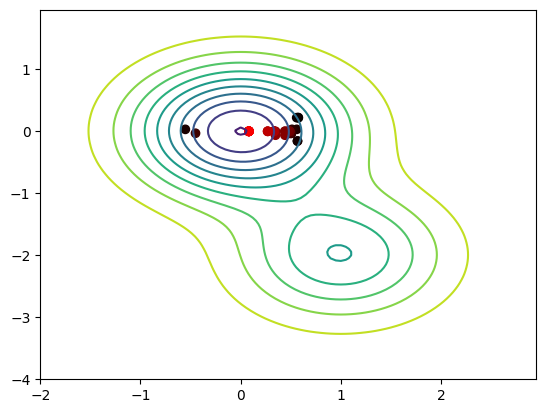

In [9]:
def generate_data(n=1000, length = 16):
  chromosomes = []
  for i in range(n):
    chromosomes.append(Chromosome(length))
  return chromosomes

chromosomes = generate_data(1000)
x = GeneticAlgorithm(chromosomes, 16, 2, lambda X, Y: 1.5 - np.exp(-X ** (2) - Y ** (2)) - 0.5 * np.exp(-(X - 1) ** (2) - (Y + 2) ** (2)), [-2, 2], 10, num_steps=50)
x.run()